# Introduction to Physics-Informed Neural Networks (PINNs)

In this tutorial we will discuss the PINNs model, introduced in the paper <i>Physics Informed Deep Learning (Part I): Data-driven
Solutions of Nonlinear Partial Differential Equations, arXiv 1711.10561</i>.<br/>
These are one of the most powerful deep learning models that are capable of solving complex nonlinear partial differential equations (PDEs) and have been successfully applied to a wide range of fields, including physics, engineering, and biology.

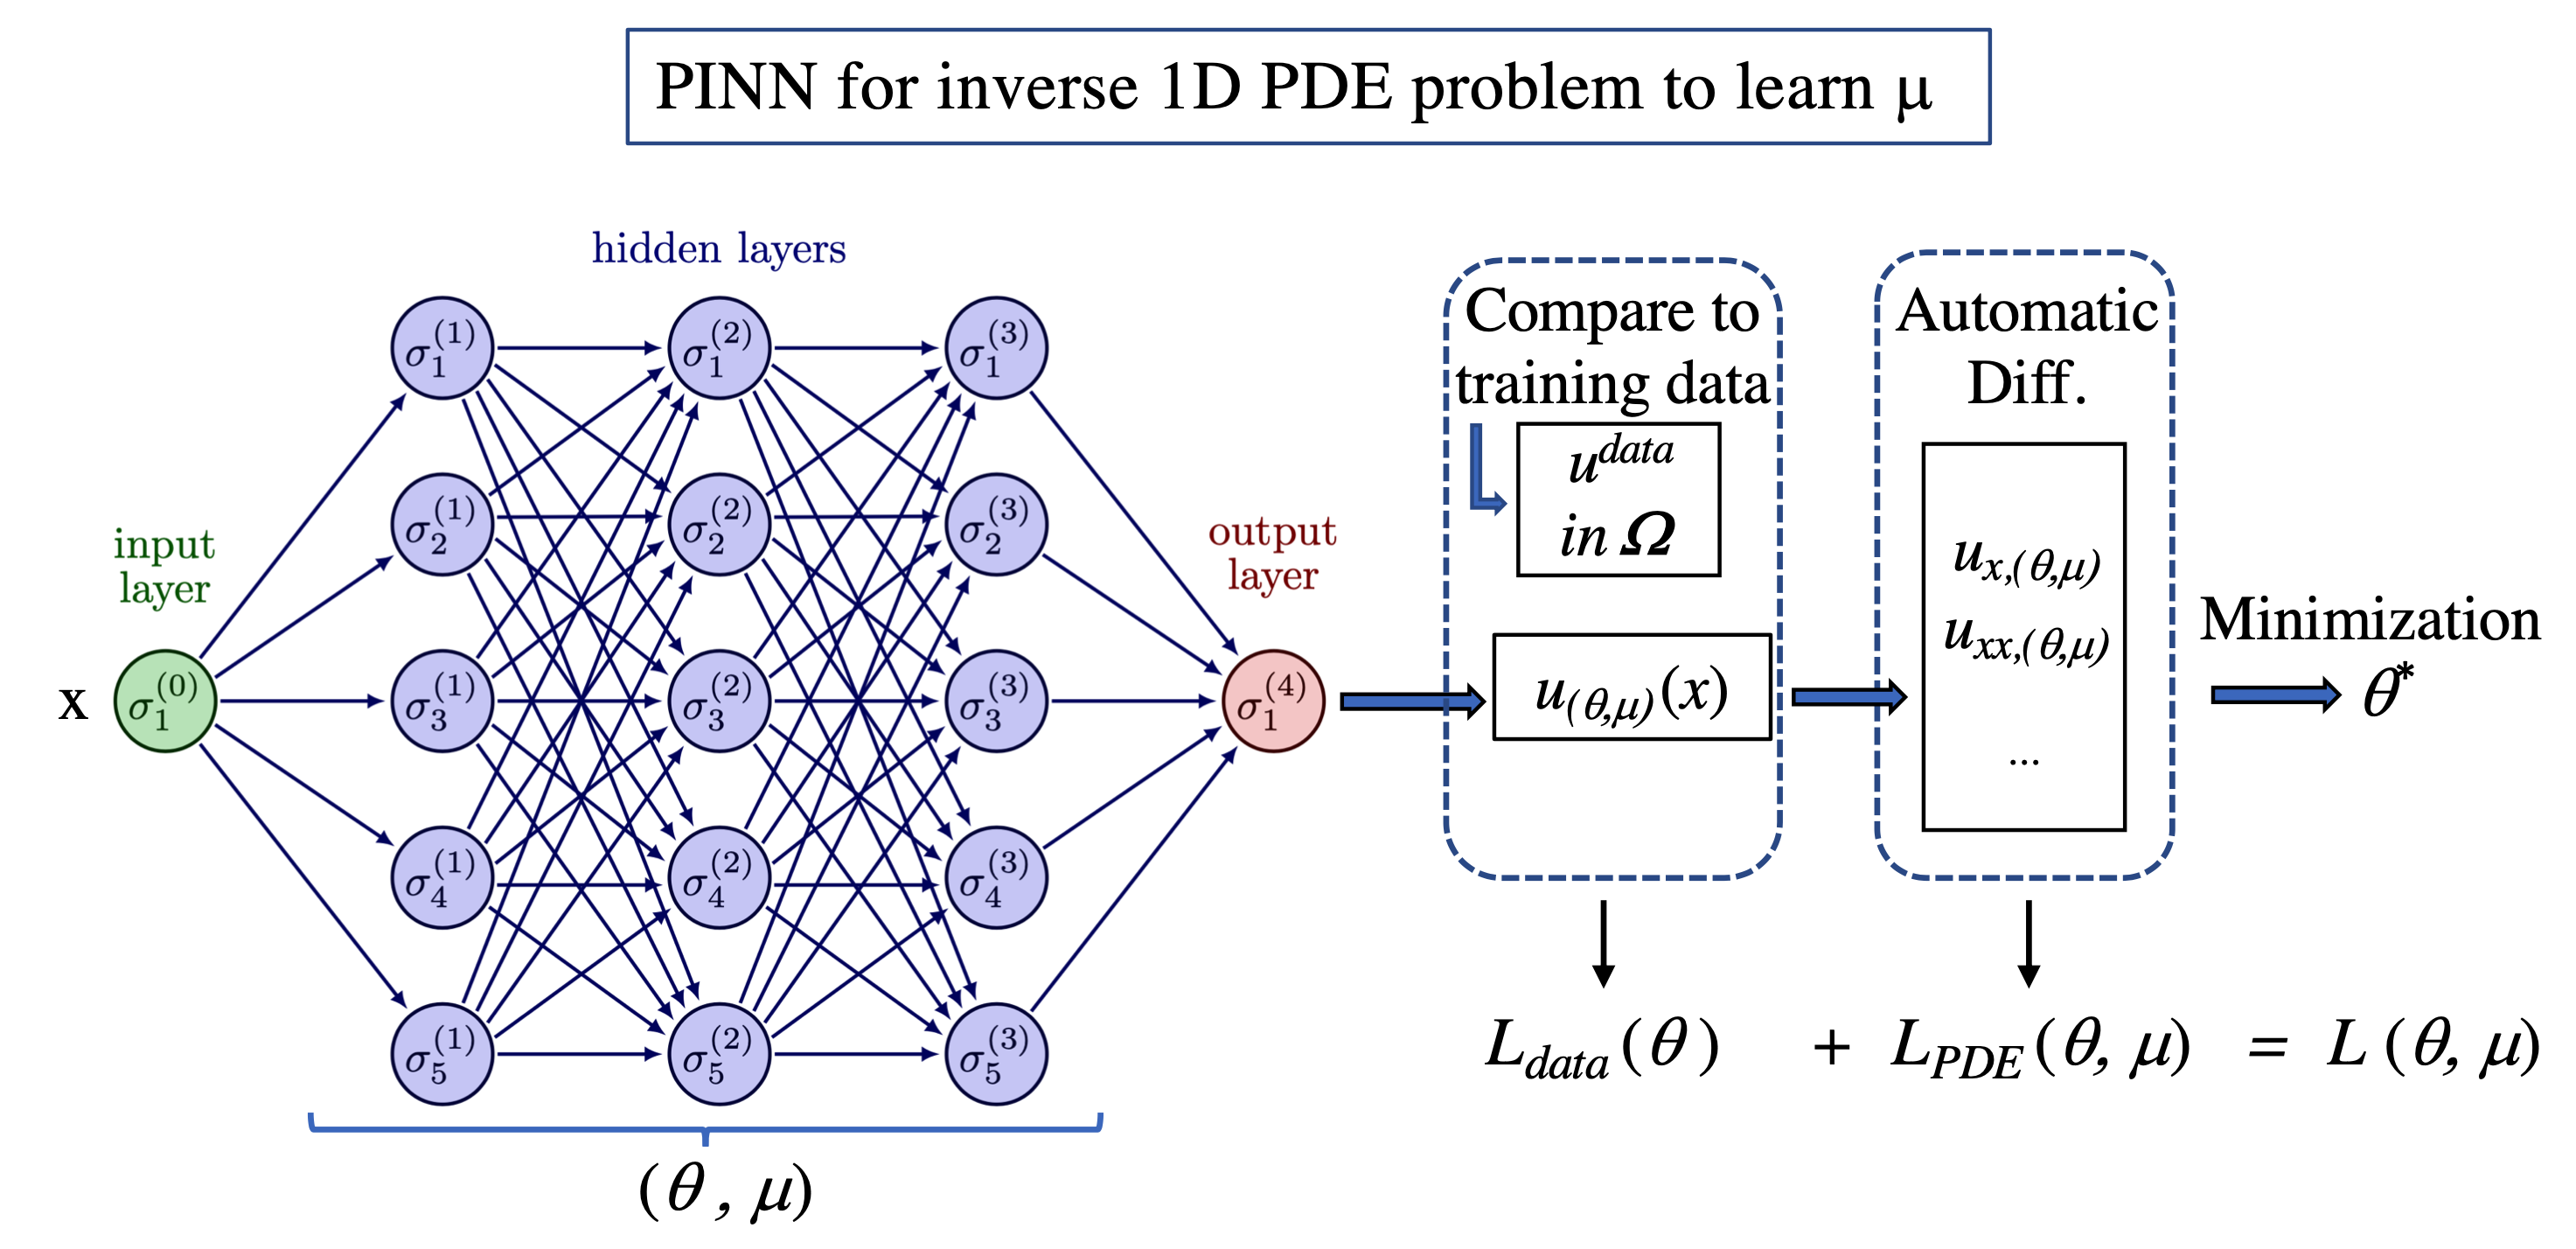
Image from https://arxiv.org/html/2403.00599v1

The basic idea is as follows:

- A feed-forward neural network takes the spatial coordinate $x$ (or $[x,t]$ for time-dependent problems) as input and produces a prediction $u_{\theta,\mu}(x)$, where $\theta$ represents the network’s trainable parameters and $\mu$ may represent unknown parameters in the PDE.
- The model is trained using two loss terms:
    - Data Loss: The error between the network’s prediction and any observed data.
    - Physics Loss: A loss that enforces the differential equation. This is done by automatically differentiating the network output (using automatic differentiation) and ensuring that the computed derivatives satisfy the PDE.

The two loss components are combined during training so that the network learns a solution that both fits the data and adheres to the governing physical laws.

>Note:
The original PINNs paper deals with time-dependent problems, and hence this tutorial starts with a simple 1D steady-state problem to illustrate the concept and then moves on to discuss the implementation of PINNs for a 2D (space-time) problem.

# Colab

This tutorial is designed to be executed in Google Colab. Click the badge below to open it directly in Colab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Introduction_to_PINNs.ipynb)

In [21]:
!pip install --pre deepchem

/home/spellsharp/anaconda3/envs/deepchem/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# PyTorch PINNModel

## Part 1. PINNModel for the 1D Steady-State Heat Equation

In the steady state, the 1D heat equation reduces to

$$
u''(x) = 0,
$$

with boundary conditions (for example):

$$
u(0) = 0 \quad \text{and} \quad u(1) = 1.
$$

The exact solution is linear:

$$
u(x) = (u(1)-u(0)) \, x + u(0) = x.
$$


### Importing modules

In [22]:
import deepchem as dc
from deepchem.models.torch_models import PINNModel
import torch
import numpy as np
import matplotlib.pyplot as plt

### 1. Define the Neural Network

DeepChem's PINNModel acts like a wrapper around a neural network as it only enforces its loss function onto the same model. If a model is not provided, then PINNModel will use a pre-defined neural network.

In [23]:
class HeatNet1D(torch.nn.Module):
    def __init__(self):
        super(HeatNet1D, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, 64), # in_features is 1 for 1D heat equation
            torch.nn.Tanh(),
            torch.nn.Linear(64, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        return self.net(x)

model = HeatNet1D().to('cuda' if torch.cuda.is_available() else 'cpu')

### 2. Define the PDE Residual (Physics Loss)
We also define the partial differential equation that will become our physics loss, one of the main components of PINNs.

For this steady-state problem we want to enforce $u''(x)=0$.

A simple way to do this is to require that the first derivative equals a constant derivative (here the simplest form is $u''(x)=0$). For our purposes we can define the residual as

$$
\text{Residual} = \frac{du}{dx} - \frac{d^2u}{dx^2},
$$

Although note that for the exact solution $u(x)=x$, we have $u'(x)=1$ and $u''(x)=0$, so it is better to enforce simply $u''(x)=0$. 

In our example, we stick with the originally provided residual for demonstration.

In [24]:
def heat_equation_residual(u, x):
    x.requires_grad_(True)
    du_dx = torch.autograd.grad(u.sum(), x, create_graph=True, retain_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx.sum(), x, create_graph=True, retain_graph=True)[0]
    return du_dx - d2u_dx2  # Let alpha be 1.0

### 3. Set up Boundary Data
We enforce Dirichlet boundary conditions at $x=0$ and $x=1$

In [25]:
boundary_data = {
    'dirichlet': {
        'points': torch.tensor([[0.0], [1.0]], dtype=torch.float32),
        'values': torch.tensor([[0.0], [1.0]], dtype=torch.float32)
    }
}

### 4. Generate Training Data

For this demonstration the training dataset is generated from the exact solution. (In practice, observational data may contain noise.) Here we simply generate points in the interior of the domain and combine them with the boundary points.

In [26]:
x_data = torch.linspace(0, 1, 2000)[1:-1].reshape(-1, 1)
x_boundary = torch.tensor([[0.0], [1.0]])
x = torch.cat([x_data, x_boundary], dim=0)
y = x.clone()
dataset = dc.data.NumpyDataset(X=x.numpy(), y=y.numpy())

### 5. Train the PINNModel

DeepChem's PINNModel wraps your network and automatically enforces both data loss (fitting the provided labels) and physics loss (enforcing the PDE) on the same model.

In [27]:
pinn_model = PINNModel(
    model=model,
    pde_fn=heat_equation_residual,
    boundary_data=boundary_data,
)
pinn_model.fit(dataset, nb_epoch=200)

0.004743625819683075

### 6. Evaluate on Test Data

Generate test points and compare the model predictions with the exact solution $u(x)=x$.

In [28]:
x_vals = np.linspace(0, 1, 200).reshape(-1, 1)
u_vals = x_vals.copy() # u_vals = (u1 - u0) * x + u0; but boundary values u0 and u1 are 0 and 1 respectively
u_pred = pinn_model.predict(x_vals)
mse = torch.mean((u_pred - u_vals) ** 2)
print("Test MSE:", mse.item())

Test MSE: 0.004094871287936663


### 6. Visualize Predictions

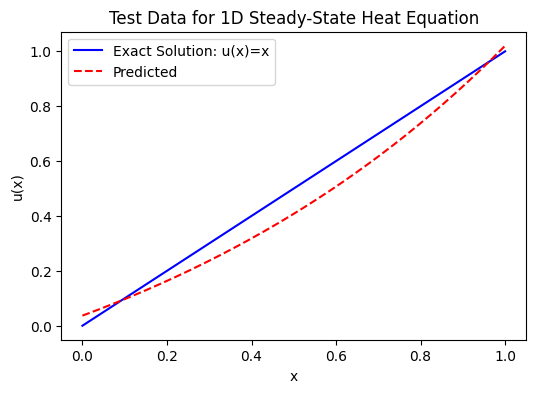

In [29]:
plt.figure(figsize=(6, 4))
plt.plot(x_vals, u_vals, 'b-', label='Exact Solution: u(x)=x')
plt.plot(x_vals, u_pred.cpu().detach().numpy(), 'r--', label='Predicted')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Test Data for 1D Steady-State Heat Equation')
plt.legend()
plt.show()

## Part 2. Fitting the PINNModel to 2D (Space-Time) Heat Equation

For the time-dependent heat equation, the PDE is given by

$$
u_t = u_{xx},
$$

with boundary conditions in space (e.g., $u(0,t)=0$ and $u(1,t)=0$) and an initial condition (e.g., $u(x,0)=\sin(\pi x)$). The exact solution is

$$
u(x,t)=\sin(\pi x)e^{-\pi^2t}.
$$


### 1. Define the 2D Neural Network

The network now accepts a 2D input $[x,t]$.


In [30]:
class HeatNet2D(torch.nn.Module):
    def __init__(self):
        super(HeatNet2D, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 64), # We need to change the input dimensions to 2 for 2D
            torch.nn.Tanh(),
            torch.nn.Linear(64, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        return self.net(x)

model = HeatNet2D().to('cuda' if torch.cuda.is_available() else 'cpu')

### 2. Define the PDE Residual for 2D

We now compute partial derivatives with respect to $x$ and $t$. For the heat equation, we enforce:

$$
u_t − u_{xx} = 0
$$

In [31]:
def heat_equation_residual_2d(u_pred, x):
    """Compute residual for heat equation.
    Args:
        u_pred: predicted values from the model
        x: input coordinates where we compute derivatives
    """
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    x.requires_grad_(True)
    
    grads = torch.autograd.grad(u_pred.sum(), x, create_graph=True)[0]
    du_dx = grads[:, 0]  # Derivative w.r.t space, we don't need to use this now
    du_dt = grads[:, 1]  # Derivative w.r.t time
    
    d2u_dx2 = torch.autograd.grad(du_dx.sum(), x, create_graph=True)[0][:, 0]
    
    return du_dt - d2u_dx2  # Correct residual for u_t = u_xx

### 3. Set Up Boundary Data for 2D

Boundary data for the 2D heat equation is a little different compared to boundary data for the 1D equation. For 2D heat equation, we want to enforce the dirichlet boundary conditions in space for all times.

- Spatial boundaries: $u(0,t)=0$ and $u(1,t)=0$ for all $t \in [0,1]$,
- Initial condition: $u(x,0)=\sin(\pi x)$ for $x \in [0,1]$.

We combine these into a single boundary data dictionary (using the same format as before).

In [32]:
def generate_boundary_data(n_boundary=100):
    """
    Generate boundary points for the heat equation.
    We enforce:
      - Left boundary: x=0 for t in [0,1] with u(0,t)=0,
      - Right boundary: x=1 for t in [0,1] with u(1,t)=0,
      - Initial condition: t=0 for x in [0,1] with u(x,0)=sin(pi*x).
      
    Returns:
      points: A torch tensor of shape [N, 2] with combined boundary coordinates.
      values: A torch tensor of shape [N, 1] with the corresponding u values.
    """
    # Left boundary: x=0, t in [0,1]
    t_vals = np.linspace(0, 1, n_boundary)
    bc_left = np.column_stack((np.zeros(n_boundary), t_vals))
    bc_left_values = np.zeros((n_boundary, 1))
    
    # Right boundary: x=1, t in [0,1]
    bc_right = np.column_stack((np.ones(n_boundary), t_vals))
    bc_right_values = np.zeros((n_boundary, 1))
    
    # Initial condition: t=0, x in [0,1]
    x_vals = np.linspace(0, 1, n_boundary)
    bc_initial = np.column_stack((x_vals, np.zeros(n_boundary)))
    bc_initial_values = np.sin(np.pi * bc_initial[:, 0:1])
    
    points = torch.tensor(np.concatenate((bc_left, bc_right, bc_initial), axis=0), dtype=torch.float32)
    values = torch.tensor(np.concatenate((bc_left_values, bc_right_values, bc_initial_values), axis=0), dtype=torch.float32)
    
    return points, values

In [33]:
points, values = generate_boundary_data(n_boundary=100)

boundary_data_2d = {
    'dirichlet': {
        'points': points,
        'values': values
    }
}

### 4. Generate the Dataset

We generate interior points on a grid over the $[0,1]\times[0,1]$ domain and compute the exact solution

$$
u(x,t)=\sin(\pi x)e^{-\pi^2t}.
$$

To simulate observational noise, we add slight Gaussian noise to 50\% of the data points.


In [34]:
def generate_dataset(n_points=2000, noise_std=0.02):
    x_vals = np.linspace(0, 1, int(np.sqrt(n_points)))
    t_vals = np.linspace(0, 1, int(np.sqrt(n_points)))
    X, T = np.meshgrid(x_vals, t_vals)
    
    # Data should be a tensor of shape (n_samples, 2)
    X_flat = np.stack([X.flatten(), T.flatten()], axis=1)
    
    y = np.sin(np.pi * X_flat[:, 0]) * np.exp(- (np.pi ** 2) * X_flat[:, 1])
    y = y.reshape(-1, 1)

    mask = np.random.rand(y.shape[0], 1) < 0.5
    noise = np.random.normal(0, noise_std, size=y.shape)
    y[mask] += noise[mask]
    return X_flat, y

X, y = generate_dataset()
dataset = dc.data.NumpyDataset(X=X, y=y)

print("Training dataset shape:", dataset.X.shape)

Training dataset shape: (1936, 2)


### 5. Training the PINNModel

In [35]:
pinn_model = dc.models.torch_models.PINNModel(
    model=model,
    pde_fn=heat_equation_residual_2d,
    boundary_data=boundary_data_2d,
    data_weight=1.0,
    physics_weight=1.0
)
pinn_model.fit(dataset, nb_epoch=200)

0.0020654244720935823

### 6. Evaluate on Test Data

In [36]:
x_test = torch.linspace(0, 1, 100).unsqueeze(1)
t_test = torch.zeros_like(x_test)
X_test = torch.cat([x_test, t_test], dim=1)
with torch.no_grad():
    y_pred = pinn_model.predict(X_test)

y_true = torch.sin(torch.pi * x_test) * torch.exp(- (torch.pi**2) * t_test)
mse = torch.mean((y_pred - y_true) ** 2)
print("Test MSE:", mse.item())

Test MSE: 0.0009029153152368963


### 7. Visualise Predictions

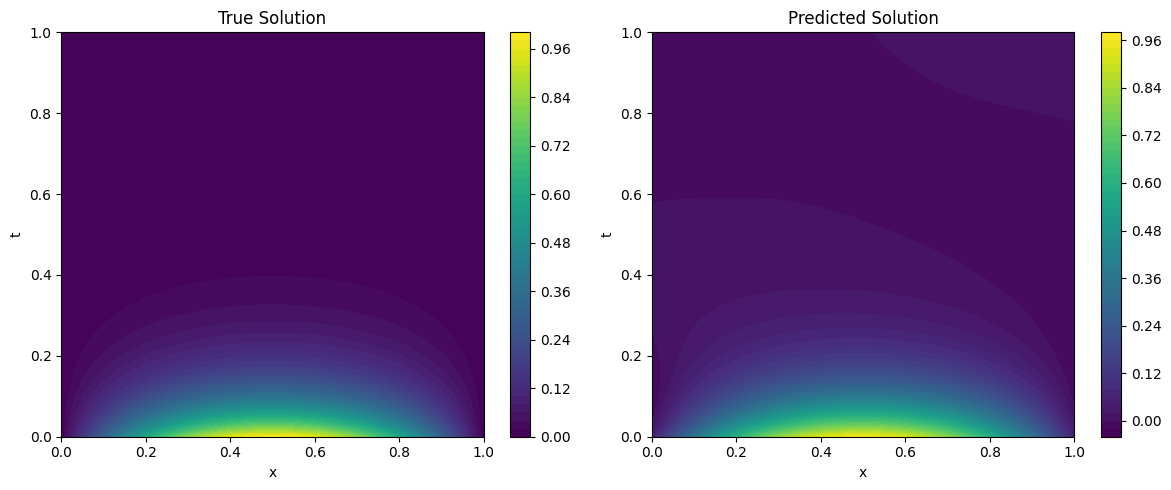

In [37]:
x_vals = np.linspace(0, 1, 100)
t_vals = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_vals, t_vals)
X_test = np.hstack((X.reshape(-1, 1), T.reshape(-1, 1)))
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

with torch.no_grad():
    y_pred = pinn_model.predict(X_test_tensor).numpy()
U_pred = y_pred.reshape(100, 100)

U_true = np.sin(np.pi * X) * np.exp(- (np.pi ** 2) * T)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.contourf(X, T, U_true, levels=50, cmap='viridis')
plt.colorbar()
plt.title("True Solution")
plt.xlabel("x")
plt.ylabel("t")

plt.subplot(1, 2, 2)
plt.contourf(X, T, U_pred, levels=50, cmap='viridis')
plt.colorbar()
plt.title("Predicted Solution")
plt.xlabel("x")
plt.ylabel("t")

plt.tight_layout()
plt.show()